In [133]:
import numpy as np
from phi.torch.flow import *

N = 128
grids_xt = np.meshgrid(np.linspace(-1,1,N), np.linspace(0,1,33), indexing = 'ij')
grid_x, grid_t = [torch.Tensor(t).float() for t in grids_xt]

In [134]:
print("grid_x : ", grid_x.size())
print("grid_t : ", grid_t.size())

grid_x :  torch.Size([128, 33])
grid_t :  torch.Size([128, 33])


In [135]:
from src.network import Network
from phi.torch.flow import math

n_layers = 2
hidden_dims = 8
output_dims = 1

network = Network(n_layers, hidden_dims, output_dims)
grid_u = network(grid_x, grid_t).unsqueeze(0)

print("grid_u : ", grid_u.size())

grid_u :  torch.Size([1, 128, 33, 1])


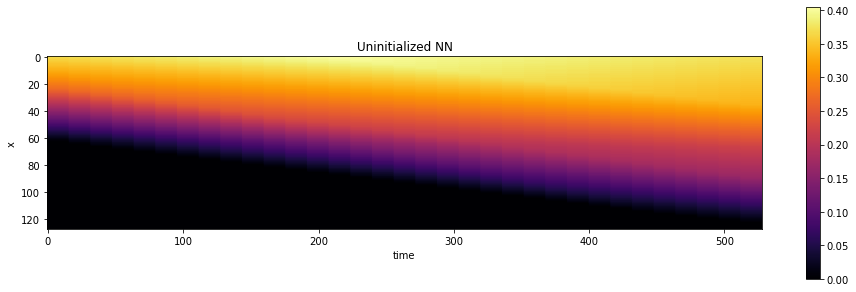

In [136]:
from src.utils import show_state

show_state(grid_u, "Uninitialized NN")

In [137]:
from src.utils import boundary_tx, open_boundary
from src.utils import loss_burgers_equation
import torch.nn as nn

# Boundary Loss
N_SAMPLE_POINTS_BND = 128
x_bc, t_bc, u_bc = [
    torch.concat([v_t0, v_x], axis = 0) for v_t0, v_x in zip(
        boundary_tx(N_SAMPLE_POINTS_BND, u_precomputed = None), 
        open_boundary(N_SAMPLE_POINTS_BND)
    )
]

loss_u = torch.norm(network(x_bc,t_bc)[:,0] - u_bc)

# Physics Loss 
N_SAMPLE_POINTS_INNER = 1024
x_ph = torch.rand(N_SAMPLE_POINTS_INNER).uniform_(-1,1)
t_ph = torch.rand(N_SAMPLE_POINTS_INNER)
loss_ph = torch.norm(loss_burgers_equation(network(x_ph, t_ph)[:,0], x_ph, t_ph, mu = None))

# combine both loss
ph_factor = 1.0
loss = loss_u + loss_ph * ph_factor

# optimize
optimizer = torch.optim.Adam(network.parameters(), lr = 1e-3)

STEPS = 1024 * 2
verbose = 128

for step in range(STEPS):

    optimizer.zero_grad()
    loss_u = torch.norm(network(x_bc,t_bc)[:,0] - u_bc)
    loss_ph = torch.norm(loss_burgers_equation(network(x_ph, t_ph)[:,0], x_ph, t_ph, mu = None))
    loss = loss_u + loss_ph * ph_factor
    loss.backward()
    optimizer.step()

    if step % verbose == 0:
        print("step : {}, loss : {:.3f}".format(step+1, loss.detach().data))

step : 1, loss : 12.061
step : 129, loss : 8.919
step : 257, loss : 7.367
step : 385, loss : 6.901
step : 513, loss : 6.774
step : 641, loss : 6.765
step : 769, loss : 6.757
step : 897, loss : 6.747
step : 1025, loss : 6.748
step : 1153, loss : 6.754
step : 1281, loss : 6.762
step : 1409, loss : 6.772
step : 1537, loss : 6.778
step : 1665, loss : 6.782
step : 1793, loss : 6.785
step : 1921, loss : 6.787


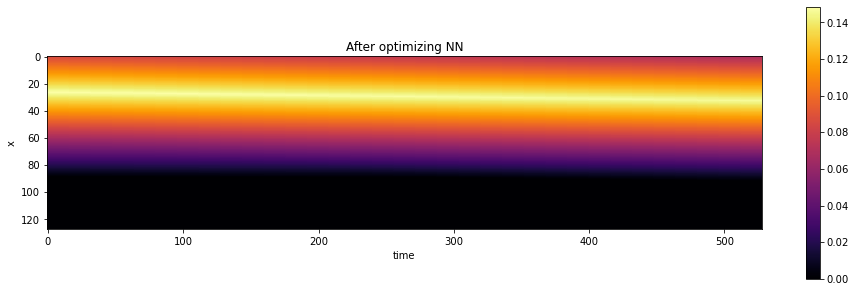

In [138]:
# after optimizing
grid_u = network(grid_x, grid_t).unsqueeze(0)
show_state(grid_u, "After optimizing NN")

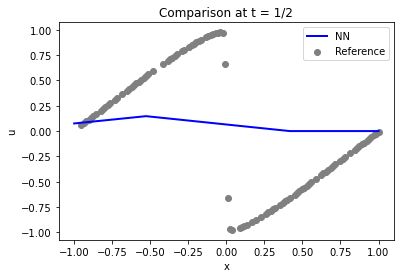

In [139]:
BC_TX = 16
uT = grid_u[0,:,BC_TX,0].detach().numpy()

import pylab as plt
fig = plt.figure().gca()
fig.plot(np.linspace(-1,1,len(uT)), uT, lw = 2, color = 'blue', label = 'NN')
fig.scatter(x_bc[0:100].detach().numpy(), u_bc[0:100].detach().numpy(), color = 'gray', label = 'Reference')
plt.title('Comparison at t = 1/2')
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.show()

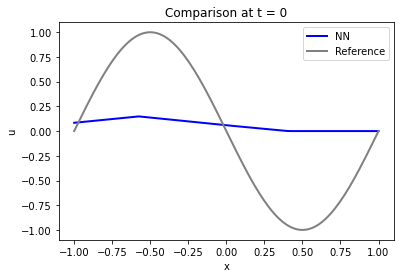

In [142]:
# ground truth solution at t = 0
t0gt = np.asarray([[-np.sin(np.pi * x) * 1.0] for x in np.linspace(-1,1,N)])
velP0 = grid_u[0,:,0,0].detach().numpy()

fig = plt.figure().gca()
fig.plot(np.linspace(-1,1,len(velP0)), velP0, lw = 2, color = 'blue', label = 'NN')
fig.plot(np.linspace(-1,1,len(t0gt)), t0gt, lw = 2, color = 'gray', label = 'Reference')
plt.title('Comparison at t = 0')
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.show()

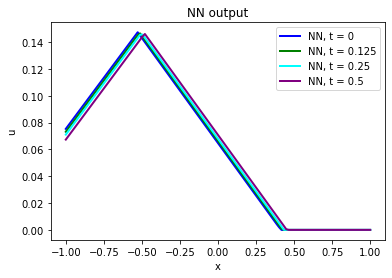

In [145]:
# ground truth solution at t = 0
t0gt = np.asarray([[-np.sin(np.pi * x) * 1.0] for x in np.linspace(-1,1,N)])
velP = [grid_u[0,:,x,0].detach().numpy() for x in range(33)]

STEPS = 32 - BC_TX

fig = plt.figure().gca()
fig.plot(np.linspace(-1,1,len(velP[0])), velP[BC_TX + 0], lw = 2, color = 'blue', label = 'NN, t = 0')
fig.plot(np.linspace(-1,1,len(velP[0])), velP[BC_TX + STEPS//4], lw = 2, color = 'green', label = 'NN, t = 0.125')
fig.plot(np.linspace(-1,1,len(velP[0])), velP[BC_TX + STEPS//2], lw = 2, color = 'cyan', label = 'NN, t = 0.25')
fig.plot(np.linspace(-1,1,len(velP[0])), velP[BC_TX + STEPS-1], lw = 2, color = 'purple', label = 'NN, t = 0.5')

#fig.plot(np.linspace(-1,1,len(t0gt)), t0gt, lw = 2, color = 'gray', label = 'Reference')
plt.title('NN output')
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.show()